# Black box synthesis example


This creates a user defined assertion cell to wrap an external verilog module under the hood.
The `user_assert` blackbox contains a simulation dummy that can be used to print out a warning. When inferring through yosys, a cell will be created that maps to the externally defined [`user_assert.v`](../../myhdl/test/conversion/toYosys/aux/assert.v) verilog implementation.

In [1]:
from myhdl import *
from myhdl.conversion import yshelper as ys

@blackbox
def user_assert(a, b, EN):
	"User defined assert"

	q = Signal(intbv()[len(a):])

	@always_comb
	def dummy():
		"Dummy simulation to satisfy myhdl"
		q.next = a == b

	@synthesis(ys.yosys)
	def implementation(module, interface):
		"Adds an assert cell for a == b"
		name = interface.name

		in_a = interface.addWire(a)
		in_b = interface.addWire(b)
		q = module.addSignal(ys.PID("eq"), 1)

		en = ys.ConstSignal(EN, 1)

		assert_inst = module.addEq(ys.ID(name + "_eq"), in_a, in_b, q)

		c = module.addCell(name + "_cell", "user_assert", True)
		c.setPort("COND", q)

	return dummy, implementation


This test module executes two LFSR in parallel and feeds them into the user_assert module.
If the values don't match, the underlying assertion module [user_assert.v](../../myhdl/test/conversion/toYosys/aux/assert.v) stops the simulation.

In [2]:
from lfsr8 import lfsr8

@block
def my_assert_success(clk, ce, reset, dout, debug):
	a, b = [ Signal(modbv(0)[8:]) for i in range(2) ]
	START_VAL = 0
	inst_lfsr1 = lfsr8(clk, 1, reset, START_VAL, a)
	inst_lfsr2 = lfsr8(clk, 1, reset, START_VAL, b)

	# Need a dummy instance to drive dout
	@always_comb
	def dummy():
		dout.next = a

	inst_assert = user_assert(a, b, 1)

	return instances()

## Run synthesis

In [3]:
# Import cosimulation object wrapper:
from ys_aux import mapped_uut_assert, tb_unit
# Select unit and general reset method:
UNIT = my_assert_success
arst = False

# Declare the signals:    
clk = Signal(bool())
debug = Signal(bool(0))
ce = Signal(bool())
dout = Signal(intbv()[8:])
reset = ResetSignal(0, 1, isasync = arst)

# Create an instance of the test unit for conversion:
entity = UNIT(clk, ce, reset, dout, debug)
name = entity.func.__name__
design = ys.Design(name)
# Convert into synthesis RTLIL:
entity.convert("yosys_module", design, name=name, trace=False)

# Write out the verilog post-synthesis code for the cosimulation object (further below)
design.write_verilog(design.name, True)

CREATE Module: 'my_assert_success'
Adding module with name: my_assert_success_1_1_1_8_1
VISIT INSTANCES
++++++++  lfsr8_1_c1_1_c0_8  ++++++++
PASSIVE wire clk <- clk
CONST wire
PASSIVE wire reset <- reset
CONST wire
ACTIVE wire a -> dout
++++++++  lfsr8_1_c1_1_c0_8  ++++++++
PASSIVE wire clk <- clk
CONST wire
PASSIVE wire reset <- reset
CONST wire
ACTIVE wire b -> dout
++++++++  user_assert_8_8_c1  ++++++++
ACTIVE wire a -> a
ACTIVE wire b -> b
CONST wire
DONE instancing submodules
CREATE Module: 'lfsr8_0'
Adding module with name: lfsr8_1_c1_1_c0_8
NOTICE: /home/pyosys/src/myhdl-local/example/ipynb/lfsr8.py:31 call compare attr
NOTICE: /home/pyosys/src/myhdl-local/example/ipynb/lfsr8.py:36 call compare attr
SIGNAL local: 'fb', IdString "$fb": /home/pyosys/src/myhdl-local/example/ipynb/lfsr8.py:37 MARK
VISIT INSTANCES
DONE instancing submodules
CREATE Module: 'lfsr8_1'
CREATE Module: 'user_assert_0'
	Infer blackbox: 'user_assert_0'
Adding module with name: user_assert_8_8_c1


## Running the Co-simulation

Again, the MyHDL and Cosimulation object simulation is run in parallel. When the assertion black box verilog module stops the simulation, a premature simulation end condition is fired. The output of the verilog simulation is captured, i.e. you should see an `ASSERTION FAILED` notice.

In [4]:
tb = tb_unit(UNIT, mapped_uut_assert, arst)
# Run the cosimulation:
tb.config_sim(backend = 'myhdl', timescale="1ps", trace=False)
tb.run_sim(30)
tb.quit_sim() # Quit so we can run another one

00 False  ---  00 False
1d False  ---  1d False
3a False  ---  3a False
74 False  ---  74 False
e8 False  ---  e8 False
cd False  ---  cd False
87 False  ---  87 False
13 False  ---  13 False
26 False  ---  26 False
4c False  ---  4c False
98 False  ---  98 False
2d False  ---  2d False
5a False  ---  5a False


<class 'myhdl._SuspendSimulation'>: Simulated 30 timesteps


### Excercise

Make the above simulation fail by changing the `START_VAL` from one of the lfsr8 units in `my_assert_success`

## RTL Display

Now display the black box architecture (remember to set the notebook `Trusted`):

Generating RTL image...
Display...


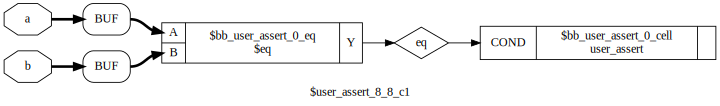

In [5]:
from ys_aux import to_svg
# Specifically choose $user_assert cell to display:
display(to_svg(design, "$user_assert_8_8_c1"))